# Tutorials - LiDAR Quickstart

## What you will learn

In this tutorial, you will learn:

* How to ingest a LAS file as 3D TileDB sparse array with [PDAL](https://pdal.io/)
* How to slice LiDAR data natively from a TileDB array
* How to visualize the sliced data.
* How to run SQL queries on LiDAR data directly from TileDB

We will use the well known [Autzen point cloud](https://github.com/PDAL/data/blob/master/workshop/autzen.laz?raw=true) dataset.

## Preparation

In TileDB Cloud, we maintain the latest changes to the PDAL TileDB plugin, but the latest release can also be installed from Conda with `conda install -c conda-forge pdal`

We will check we have the TileDB driver for PDAL and then download the Autzen LAS file we will use as follows.

In [1]:
!pdal --drivers | grep TileDB

readers.tiledb               Read data from a TileDB array.
writers.tiledb               Write data using TileDB.


In [2]:
!wget "https://github.com/PDAL/data/blob/master/workshop/autzen.laz?raw=true" -O autzen.laz

--2021-09-22 17:54:29--  https://github.com/PDAL/data/blob/master/workshop/autzen.laz?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/PDAL/data/raw/master/workshop/autzen.laz [following]
--2021-09-22 17:54:30--  https://github.com/PDAL/data/raw/master/workshop/autzen.laz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PDAL/data/master/workshop/autzen.laz [following]
--2021-09-22 17:54:30--  https://media.githubusercontent.com/media/PDAL/data/master/workshop/autzen.laz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting respo

Let's inspect this point cloud dataset with [PDAL](https://pdal.io/) (this operation takes a couple of minutes to complete).

In [3]:
!pdal info autzen.laz | jq .

{
  "file_size": 56350988,
  "filename": "autzen.laz",
  "now": "2021-09-22T17:54:55-0500",
  "pdal_version": "2.3.0 (git-version: 0800a2)",
  "reader": "readers.las",
  "stats": {
    "bbox": {
      "EPSG:4326": {
        "bbox": {
          "maxx": -123.0619599,
          "maxy": 44.06278031,
          "maxz": 615.26,
          "minx": -123.0755422,
          "miny": 44.04971882,
          "minz": 406.14
        },
        "boundary": {
          "type": "Polygon",
          "coordinates": [
            [
              [
                -123.07498674355058,
                44.04971881880167,
                406.14
              ],
              [
                -123.07554222854617,
                44.06248622815225,
                406.14
              ],
              [
                -123.06251259699623,
                44.06278030701678,
                615.26
              ],
              [
                -123.0619599185324,
                44.05001283469481,
               

## LAS Ingestion into TileDB

We first set the array name and clean up its directory from a potentially previous run.

In [4]:
import tiledb

output_array = 'arrays/autzen_tiledb'

In [5]:
import json
import shutil

# clean up any previous runs
try:
    shutil.rmtree(output_array)
except:
    pass

We will now ingest the LAS file into a TileDB array using the following PDAL pipeline.

In [6]:
initial_pipeline = [
   {
      'type': 'readers.las',
      'filename': "autzen.laz"
   },
   {
       'type' : 'filters.stats'
   },
   {
      'type': 'writers.tiledb',
      'array_name': f"{output_array}",
      'chunk_size': 10000000
   }
]

with open('pipeline.json', 'w') as f:
    json.dump(initial_pipeline, f)

In [7]:
!pdal pipeline -i pipeline.json --nostream

Let's inspect the schema of the TileDB array we created. The array has 3 dimensions and 13 attributes. TileDB provides very fast slicing on the three dimensions. The non-empty domain is the tightest 3D bounding box that contains all points in the dataset.

In [8]:
%%time
with tiledb.open(output_array) as arr:
    print(f"Non-empty domain: {arr.nonempty_domain()}")
    print(arr.schema)

Non-empty domain: ((array(635577.79), array(639003.73)), (array(848882.15), array(853537.66)), (array(406.14), array(615.26)))
ArraySchema(
  domain=Domain(*[
    Dim(name='X', domain=(-1.7976931348623157e+308, 1.7976931348623157e+308), tile='None', dtype='float64'),
    Dim(name='Y', domain=(-1.7976931348623157e+308, 1.7976931348623157e+308), tile='None', dtype='float64'),
    Dim(name='Z', domain=(-1.7976931348623157e+308, 1.7976931348623157e+308), tile='None', dtype='float64'),
  ]),
  attrs=[
    Attr(name='Intensity', dtype='uint16', var=False, nullable=False, filters=FilterList([Bzip2Filter(level=5), ])),
    Attr(name='ReturnNumber', dtype='uint8', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
    Attr(name='NumberOfReturns', dtype='uint8', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
    Attr(name='ScanDirectionFlag', dtype='uint8', var=False, nullable=False, filters=FilterList([Bzip2Filter(level=5), ])),
    Attr(name='Edg

## Slicing LiDAR data from TileDB
We next slice a region directly from the TileDB array, which is executed very fast. The result is stored directly in a pandas dataframe, using zero-copy techniques for performance.

In [9]:
%%time
with tiledb.open(output_array) as arr:
    df = arr.df[636800:637800, 851000:853000, 406.14:615.26]

df

CPU times: user 6.03 s, sys: 1.16 s, total: 7.19 s
Wall time: 971 ms


,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,637475.45,851804.30,415.49,1,1,1,1,0,2,-1.0,122,7331,248289.538944,111,112,98
1,637174.99,852014.95,415.49,1,1,1,1,0,2,10.0,122,7332,248680.116914,114,119,113
2,637371.69,851840.65,415.51,1,1,1,0,0,2,-12.0,124,7330,247564.723623,134,136,113
3,637244.90,851873.25,415.51,1,1,1,0,0,2,0.0,124,7331,248288.150659,138,145,124
4,637169.48,851998.29,415.51,1,1,1,1,0,2,-11.0,124,7330,247565.570015,112,114,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311294,637313.84,851725.79,594.72,227,1,1,1,0,1,-9.0,128,7330,247565.111934,232,233,226
1311295,637323.35,851721.87,595.08,192,1,1,1,0,1,-6.0,122,7331,248288.714738,238,241,235
1311296,637293.40,851731.40,595.11,211,1,1,1,0,1,-8.0,127,7330,247565.207689,234,238,231
1311297,637308.98,851727.35,595.24,199,1,1,0,0,1,-5.0,124,7331,248288.630259,228,228,222


We can also subselect on the columns we need

In [10]:
%%time
with tiledb.open(output_array) as arr:
    rgb_df = arr.query(attrs=["Red", "Green", "Blue"]).df[636800:637800, 851000:853000, 406.14:615.26]

rgb_df

CPU times: user 2.42 s, sys: 876 ms, total: 3.3 s
Wall time: 598 ms


,X,Y,Z,Red,Green,Blue
0,637475.45,851804.30,415.49,111,112,98
1,637174.99,852014.95,415.49,114,119,113
2,637371.69,851840.65,415.51,134,136,113
3,637244.90,851873.25,415.51,138,145,124
4,637169.48,851998.29,415.51,112,114,108
...,...,...,...,...,...,...
1311294,637313.84,851725.79,594.72,232,233,226
1311295,637323.35,851721.87,595.08,238,241,235
1311296,637293.40,851731.40,595.11,234,238,231
1311297,637308.98,851727.35,595.24,228,228,222


Or apply an attribute filter using a TileDB query pushdown

In [11]:
from tiledb import QueryCondition

with tiledb.open(output_array, mode="r") as arr:
    qc = QueryCondition("Classification == 2") # ground
    df_classification = arr.query(attr_cond=qc).df[636800:637800, 851000:853000, 406.14:615.26]

df_classification

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue
0,637475.45,851804.30,415.49,1,1,1,1,0,2,-1.0,122,7331,248289.538944,111,112,98
1,637174.99,852014.95,415.49,1,1,1,1,0,2,10.0,122,7332,248680.116914,114,119,113
2,637371.69,851840.65,415.51,1,1,1,0,0,2,-12.0,124,7330,247564.723623,134,136,113
3,637244.90,851873.25,415.51,1,1,1,0,0,2,0.0,124,7331,248288.150659,138,145,124
4,637169.48,851998.29,415.51,1,1,1,1,0,2,-11.0,124,7330,247565.570015,112,114,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372977,637762.59,852900.48,426.12,60,1,1,0,0,2,-9.0,126,7332,248675.182871,120,117,108
372978,637745.54,852913.97,426.15,81,1,1,1,0,2,-9.0,124,7332,248675.246580,135,132,120
372979,637742.38,852915.21,426.18,101,1,1,0,0,2,-9.0,126,7332,248675.259572,117,114,100
372980,637761.19,852900.16,426.28,73,1,1,0,0,2,-6.0,124,7333,249397.730513,120,117,108


## Visualization
We can plot the sliced data with matplotlib.

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def plot(pts):
    rgbs = np.array(list(zip(pts['Red'], pts['Green'], pts['Blue']))) / 255.0

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.ticklabel_format(useOffset=False)

    ax.scatter(pts['X'], pts['Y'], pts['Z'], c=rgbs)

    ax.set_xlabel('x', fontsize=20, labelpad=20)
    ax.set_ylabel('y', fontsize=20, labelpad=35)
    ax.set_zlabel('z', fontsize=20, labelpad=25)
    ax.set_title('Autzen', fontsize=20, pad=20)
    ax.view_init(60, 96)
    ax.tick_params(axis='y', pad=20)
    ax.tick_params(axis='z', pad=10)
    plt.show()

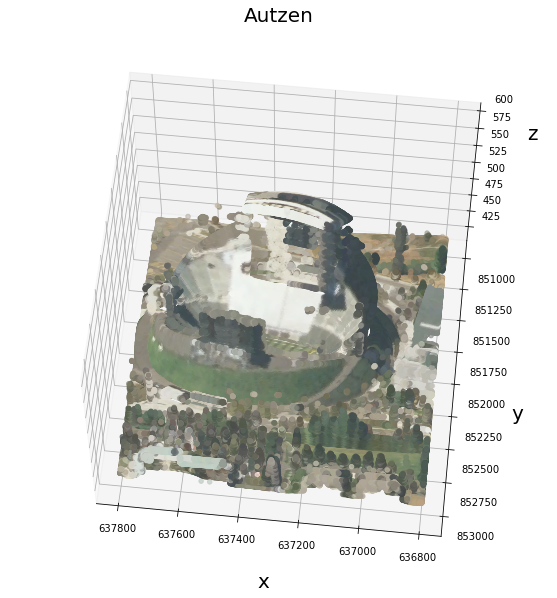

In [13]:
plot(df)

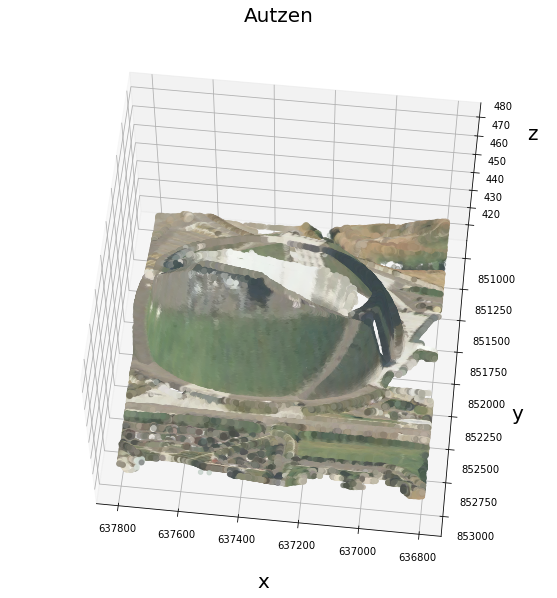

In [14]:
plot(df_classification)